In [1]:
#importacion de librerias
import pdftotext
import re
import os
import codecs
import io
import sys
import re
import unicodedata
import operator
import fasttext
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [4]:
nlp= spacy.load('es_core_news_sm')
fasttext.FastText.eprint = lambda x: None


#_SYMBOLS= set(";:,.\\-\"'()[]¿?¡!{}~<>|\t\r")
PUNCTUACTION = ";:,.\\-\"'/_*æ"
SYMBOLS = "()[]¿?¡!{}~<>|#@%=«»$"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\r ')
# Remueve stop words
def remove_stop_words(str):   
    stop_words = set(['de','la','que','el','en','y','a','los','del','se','las','por','un','para','con','no','una','su','al','lo','como','mas','pero','sus',
                     'le','ya','o','este','si','porque','esta','entre','cuando','muy','sin','sobre','tambien','me','hasta','hay','donde','quien','desde',
                     'todo','nos','durante','todos','uno','les','ni','contra','otros','ese','eso','ante','ellos','e','esto','mi','antes','algunos','que',
                     'unos','yo','otro','otras','otra','el','tanto','esa','estos','mucho','quienes','nada','muchos','cual','poco','ella','estar','estas',
                     'algunas','algo','nosotros','mi','mis','tu','te','ti','tu','tus','ellas','nosotras','vosotros','vosotras','os','mio','mia','mios',
                     'mias','tuyo','tuya','tuyos','tuyas','suyo','suya','suyos','suyas','nuestro','nuestra','nuestros','nuestras','vuestro','vuestra',
                     'vuestros','vuestras','esos','esas','estoy','estas','esta','estamos','estais','estan','este','estes','estemos','esteis','esten','estare',
                     'estaras','estara','estaremos','estareis','estaran','estaria','estarias','estariamos','estariais','estarian','estaba','estabas','estabamos',
                     'estabais','estaban','estuve','estuviste','estuvo','estuvimos','estuvisteis','estuvieron','estuviera','estuvieras','estuvieramos',
                     'estuvierais','estuvieran','estuviese','estuvieses','estuviesemos','estuvieseis','estuviesen','estando','estado','estada','estados','estadas',
                     'estad','he','has','ha','hemos','habeis','han','haya','hayas','hayamos','hayais','hayan','habre','habras','habra','habremos','habreis',
                     'habran','habria','habrias','habriamos','habriais','habrian','habia','habias','habiamos','habiais','habian','hube','hubiste','hubo','hubimos',
                     'hubisteis','hubieron','hubiera','hubieras','hubieramos','hubierais','hubieran','hubiese','hubieses','hubiesemos','hubieseis','hubiesen',
                     'habiendo','habido','habida','habidos','habidas','soy','eres','es','somos','sois','son','sea','seas','seamos','seais','sean','sere','seras',
                     'sera','seremos','sereis','seran','seria','serias','seriamos','seriais','serian','era','eras','eramos','erais','eran','fui','fuiste','fue',
                     'fuimos','fuisteis','fueron','fuera','fueras','fueramos','fuerais','fueran','fuese','fueses','fuesemos','fueseis','fuesen','sintiendo','sentido',
                     'sentida','sentidos','sentidas','siente','sentid','tengo','tienes','tiene','tenemos','teneis','tienen','tenga','tengas','tengamos','tengais',
                     'tengan','tendre','tendras','tendra','tendremos','tendreis','tendran','tendria','tendrias','tendriamos','tendriais','tendrian','tenia','tenias',
                     'teniamos','teniais','tenian','tuve','tuviste','tuvo','tuvimos','tuvisteis','tuvieron','tuviera','tuvieras','tuvieramos','tuvierais',
                     'tuvieran','tuviese','tuvieses','tuviesemos','tuvieseis','tuviesen','teniendo','tenido','tenida','tenidos','tenidas','tened'])

    
    word = ""        
    text = str.split()        
    for _text in text:        
        if _text not in stop_words:
            #Agrega al diccionario palabras que tenga 2 caracteres en adelante
            if(len(_text) > 1):                
                word += _text  + " " 
            
    return word 

#elimina caracteres especiales
def remove_esp_characters(txt):     
    text = re.sub(r'\W+',' ', txt)    
    text = re.sub(r'[ ]{2,}',' ', text)  
    return text.strip()

#reduce la palabra a su forma base
def _stemmer(text):
    stemmer = SnowballStemmer("spanish")
    _text = ""
    for t in text.split(" "):
        _text += stemmer.stem(t) + " "
    return _text

def normalize_text(input_str,
                   punct=False,
                   accents=False,
                   spaces =False,
                   stopwords = False,
                   max_dup=2):
    """
    punct=False (elimina la puntuación, True deja intacta la puntuación)
    accents=False (elimina los acentos, True deja intactos los acentos)
    max_dup=2 (número máximo de símbolos duplicados de forma consecutiva, rrrrr => rr)
    """
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        c = c.lower()
        if not punct:
            if c in SKIP_SYMBOLS_AND_SPACES:
                c = " "
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
        
    if not stopwords:
        return remove_stop_words(re.sub(r'[ ]{2,}',' ', "".join(n_str)))
    else:
        return re.sub(r'[ ]{2,}',' ', "".join(n_str)) 

#grafia la estructua counter, recibe el tamaño a gráficar
#tamaño de al gráfica y el color a graficar
def chart(counter, idx, x, y, color):
    plt.figure(figsize=(x, y))    
    plt.subplot(1, 2, 1)
    k1 = []
    v1 = []
    
    for co in counter.most_common(idx):
        k1.append(co[0])
        v1.append(co[1])
    
    k1.reverse()
    v1.reverse()    
    x1 = [i for i, _ in enumerate(k1)] 

    plt.yticks(x1, k1)
    plt.barh(x1, v1, color=color)
    
    wc=WordCloud(width = 800, height = 800,
                    background_color ='white',)
    wc.generate_from_frequencies(dict(counter.most_common(idx)))    
    #plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 2)    
    plt.imshow(wc)
    plt.axis("off")
    plt.show()  

In [27]:
def listFiles(path):
    files = os.listdir(path)
    return files

def listToString(s):     
    str1 = " " 
    return (str1.join(s))

def createTXT():    
    _punct = False
    _accents = False
    _spaces = False
    _stopwords = False

    path = 'D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/PDF/'
    entries = listFiles(path)
    text = []
    text_sp = []
    text_lemma = []
    text_stemming = []
    for e in entries:
        try:
            temp = open(path + e, 'rb')  
            pdf = pdftotext.PDF(temp)
            k = 1
            for page in pdf:     
                lema_page = nlp(page)
                text.append(normalize_text(page,punct=_punct,accents=_accents,spaces=_spaces,stopwords=True))
                text_sp.append(normalize_text(page,punct=_punct,accents=_accents,spaces=_spaces,stopwords=_stopwords))
                text_lemma.append(normalize_text(" ".join([wlemma.lemma_ for wlemma in lema_page]), punct=_punct,accents=_accents,spaces=_spaces,stopwords=True))
                text_stemming.append(_stemmer(normalize_text(page,punct=_punct,accents=_accents,spaces=_spaces,stopwords=True)))
        except Exception as inst:
            print(inst)
        


    with io.open("D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/texto/text_vf.txt", "w", encoding="utf-8") as f:
         f.write(listToString(text))    
    with io.open("D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/texto/text_sp_vf.txt", "w", encoding="utf-8") as f:
        f.write(listToString(text_sp))   
    with io.open("D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/texto/text_lemma_vf.txt", "w", encoding="utf-8") as f:
        f.write(listToString(text_lemma))   
    with io.open("D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/texto/text_stemming_vf.txt", "w", encoding="utf-8") as f:
        f.write(listToString(text_stemming))   
    return text, text_sp, text_lemma, text_stemming


In [28]:
text, text_sp, text_lemma, text_stemming = createTXT()

In [20]:
"""
se realiza una exploración de los datos que se acaban de procesar para graficar los resultados obtenido 
"""
voc = Counter()
voc_sp = Counter()
voc_lemma = Counter()
voc_stemming = Counter()

for _text in text:
    voc.update(_text.split())
for _text in text_sp:
    voc_sp.update(_text.split())
for _text in text_lemma:
    voc_lemma.update(_text.split())
for _text in text_stemming:
    voc_stemming.update(_text.split())
    
print("Vocabulario: " + str(len(voc)))
print("Vocabulario sin stopwords: " + str(len(voc_sp)))
print("Vocabulario con lematizacion: " + str(len(voc_lemma)))
print("Vocabulario con stemming: " + str(len(voc_stemming)))

Vocabulario: 34157
Vocabulario sin stopwords: 33880
Vocabulario con lematizacion: 40348
Vocabulario con stemming: 18603


| Vocabulario | Vocabulario sin stopwords | Vocabulario con lematizacion | Vocabulario con stemming | 
|:-------------:|:-------------:|:-------------:|:-------------:|
| 34,157 | 33,880 | 40,348 | 18,603

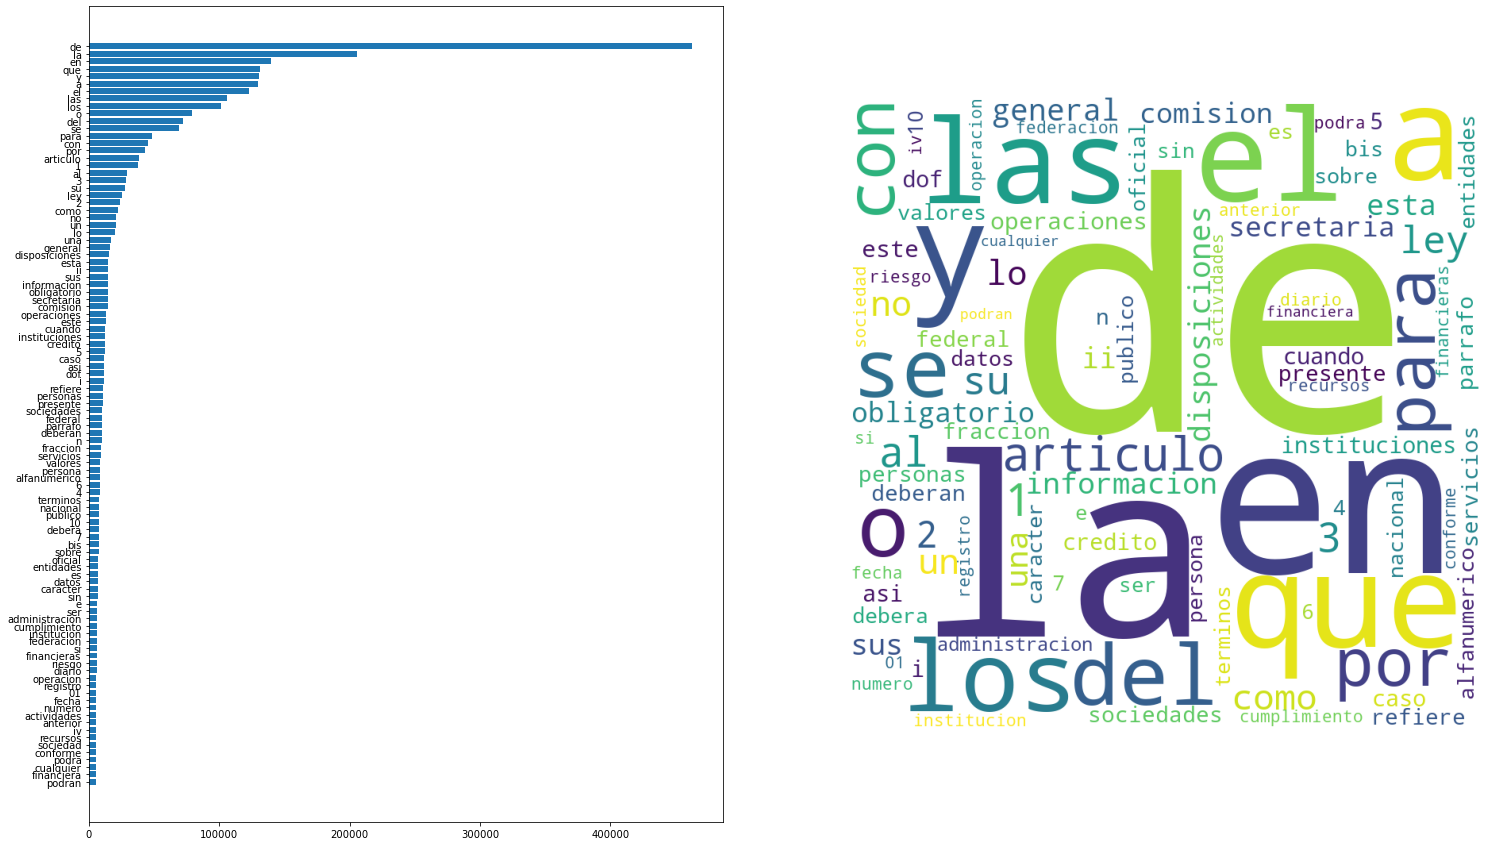

In [23]:
chart(voc,100,25,15,'#1f77b4')

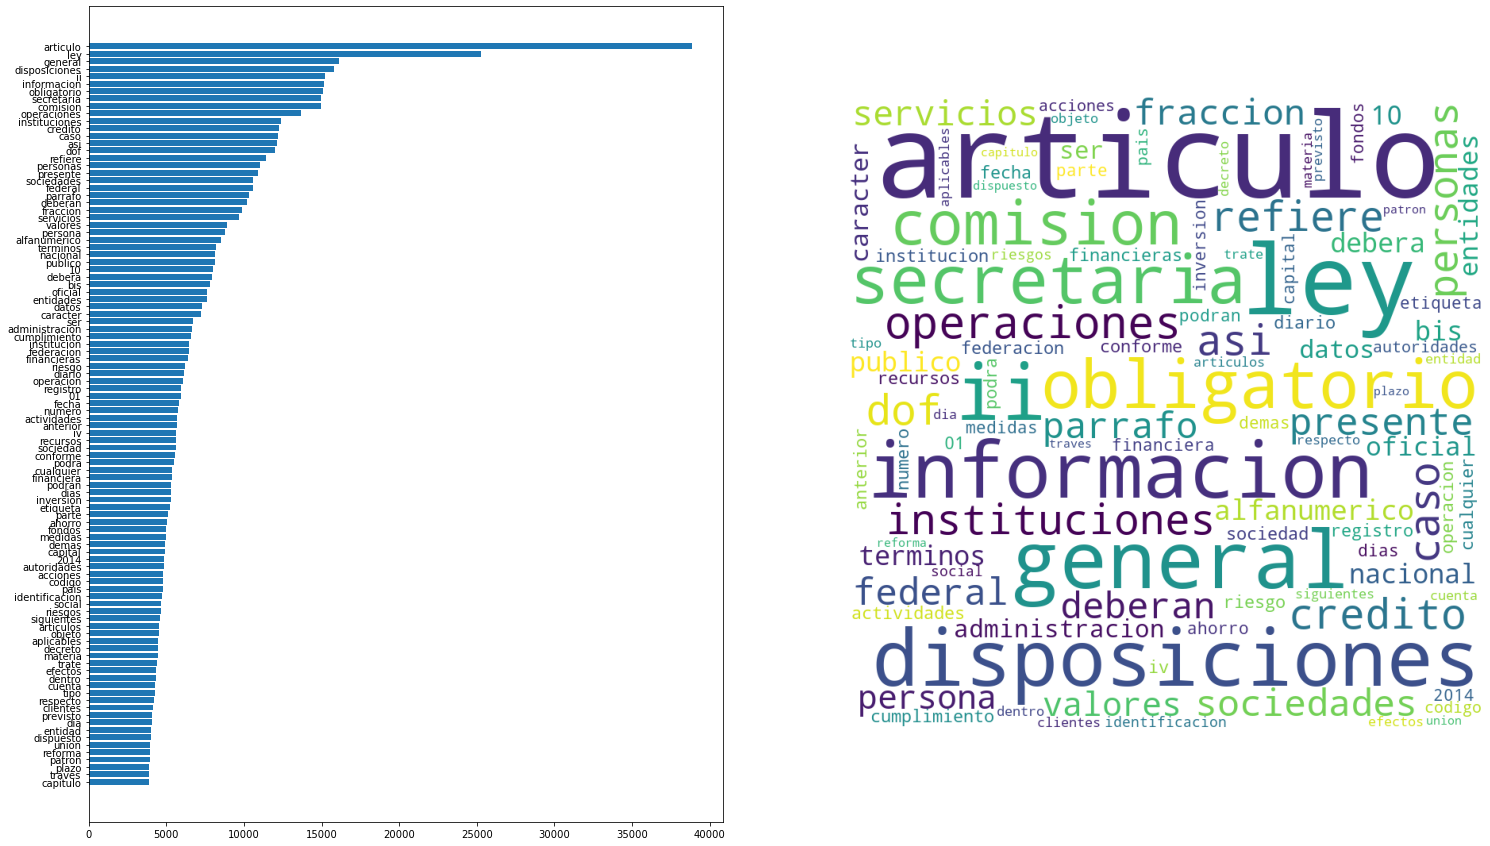

In [24]:
chart(voc_sp,100,25,15,'#1f77b4')

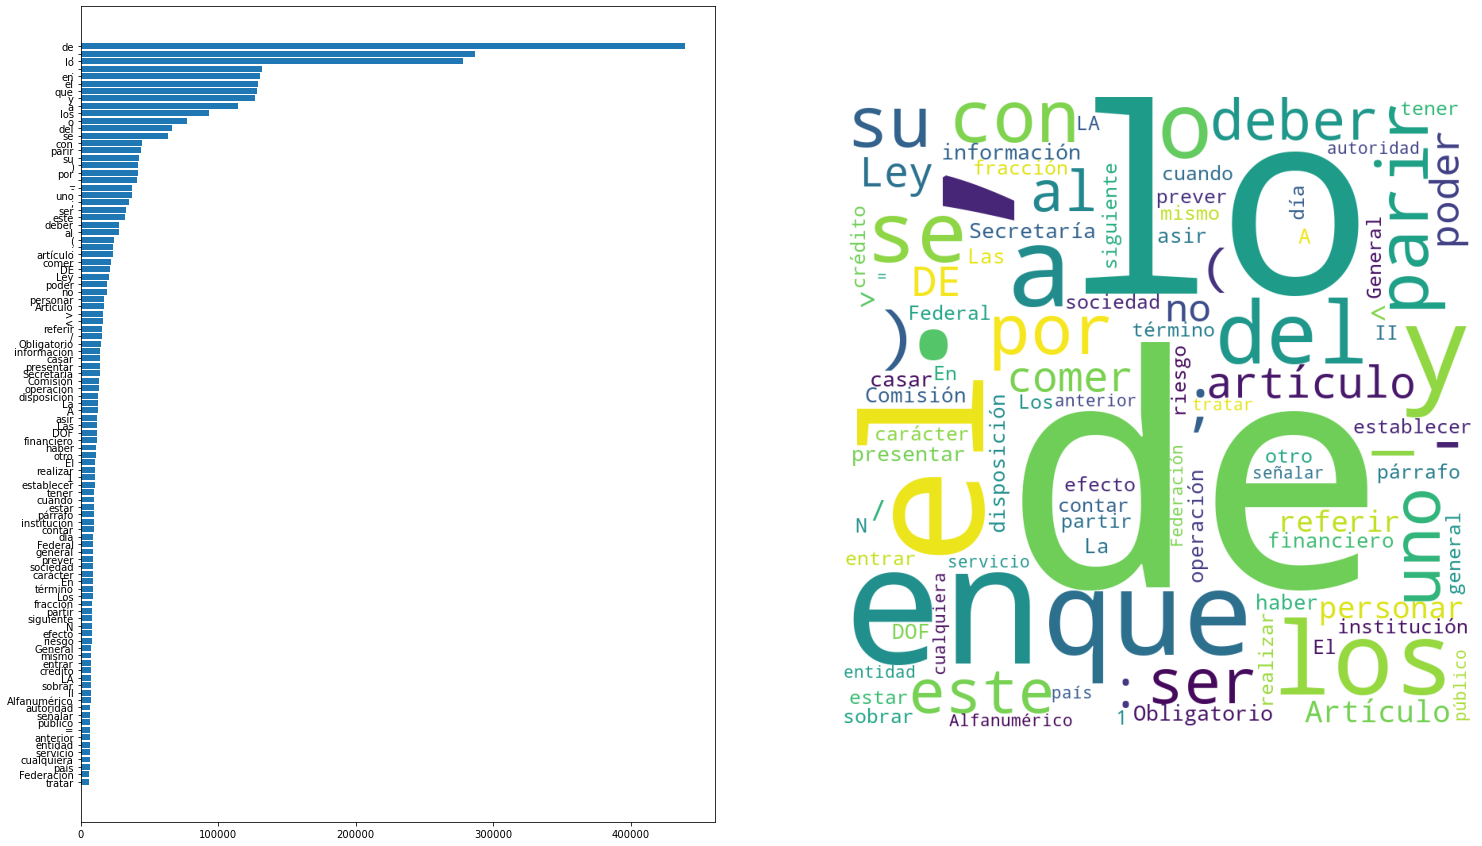

In [30]:
chart(voc_lemma,100,25,15,'#1f77b4')

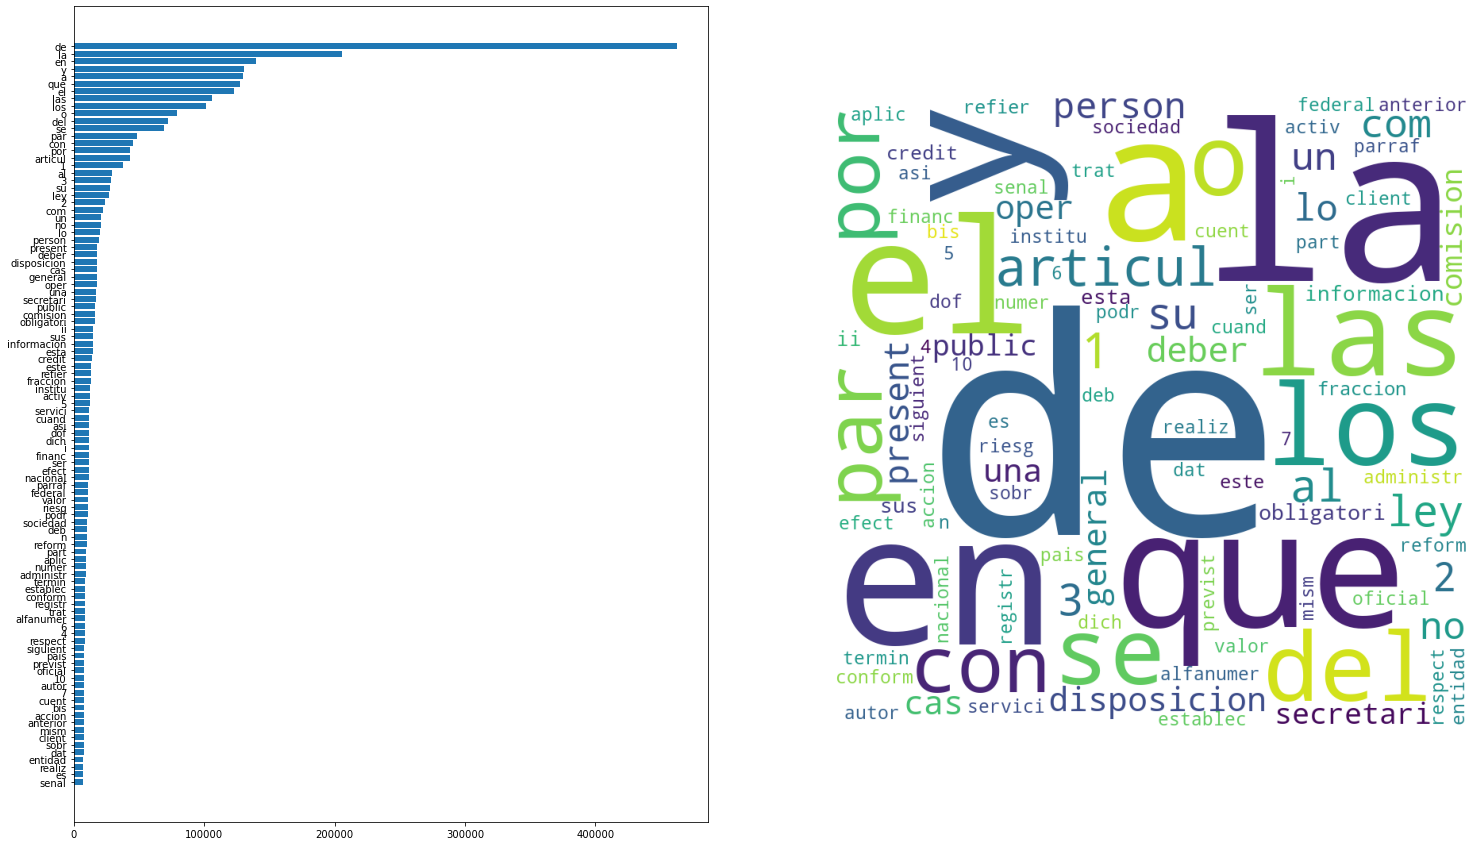

In [26]:
chart(voc_stemming,100,25,15,'#1f77b4')

In [33]:
"""
Creación de word embedding con diferentes dimensiones que van de 10,20,30,40,50, y 100
"""


#codificación de oraciones en vectores
def embeddings(sentences, ft):
    emb = []
    for sent in sentences:
        emb.append(ft.get_sentence_vector(sent))
    return emb

#comapara la similitud de las oraciones
def top_semantic_comp (embeddings_source, embeddings_target):
    # Comparación de semántica
    similarity = {}
    for s, esource in enumerate(embeddings_source):
        for t, etarget in enumerate(embeddings_target):
            similarity[ str(s) + "-" + str(t) ] = cosine_similarity([esource], [etarget])
     
    #ordena de forma ascedente la similutud de oraciones
    similarity_sort = sorted(similarity.items(), key=operator.itemgetter(1), reverse=True)    
       
    #muestra la sentencias y su porcentaje de similutud
    for s in similarity_sort: 
        idx = s[0].split("-")
        print("sentencia source:", source[int(idx[0])])
        print("sentencia target:", target[int(idx[1])])
        print("similaridad:", s[1][0][0] * 100, "%")
        print("")

        
source = [ "que son las actividades vulnerables",
           "que es una persona PEP",
           "el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México"]

target = ["quienes envian las actividades vulnerables",
    "que es una persona politicamente expuesta",
    "el trafico de drogas es un actividad principal de la delincuencia organizada en mexico"]        

## Modelo con 10 dimensiones en FastText

In [15]:
ft_10 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_vf_10.bin')

In [16]:
aembsource_10 = embeddings(source, ft_10)
aembtarget_10 = embeddings(target, ft_10)

top_semantic_comp(aembsource_10, aembtarget_10)

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 99.70231056213379 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.3984580039978 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 95.94112038612366 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.90082168579102 %

sentencia source: que es una persona PEP
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 89.73328471183777 %

sentencia source: el trafico de drogas es una de las principales vertien

## Modelo con 20 dimensiones en FastText

In [19]:
ft_20 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_vf_20.bin')

In [20]:
aembsource_20 = embeddings(source, ft_20)
aembtarget_20 = embeddings(target, ft_20)

top_semantic_comp(aembsource_20, aembtarget_20)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.26508665084839 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 99.06367063522339 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 96.07186913490295 %

sentencia source: que es una persona PEP
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 92.30706095695496 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 91.52601361274719 %

sentencia source: el trafico de drogas es una de las principales vertie

## Modelo con 30 dimensiones en FastText

In [21]:
ft_30 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_vf_30.bin')

In [22]:
aembsource_30 = embeddings(source, ft_30)
aembtarget_30 = embeddings(target, ft_30)

top_semantic_comp(aembsource_30, aembtarget_30)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 98.65227937698364 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.57863187789917 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 95.36545872688293 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 90.84480404853821 %

sentencia source: que es una persona PEP
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 87.53331899642944 %

sentencia source: el trafico de drogas es una de las principales vertie

## Modelo con 40 dimensiones en FastText

In [23]:
ft_40 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_vf_40.bin')

In [24]:
aembsource_40 = embeddings(source, ft_40)
aembtarget_40 = embeddings(target, ft_40)

top_semantic_comp(aembsource_40, aembtarget_40)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 98.75936508178711 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.30690622329712 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 95.68958282470703 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 90.45684337615967 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 86.86397075653076 %

sentencia source: que es una persona PEP

## Modelo con 50 dimensiones en FastText

In [26]:
ft_50 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_vf_50.bin')

In [27]:
aembsource_50 = embeddings(source, ft_50)
aembtarget_50 = embeddings(target, ft_50)

top_semantic_comp(aembsource_50, aembtarget_50)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 98.82535934448242 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.37633967399597 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.6186363697052 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 90.68970084190369 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 86.993807554245 %

sentencia source: que es una persona PEP
se

## Modelo con 100 dimensiones en FastText

In [28]:
ft_100 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_vf_100.bin')

In [29]:
aembsource_100 = embeddings(source, ft_100)
aembtarget_100 = embeddings(target, ft_100)

top_semantic_comp(aembsource_100, aembtarget_100)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 98.81224036216736 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.40257167816162 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.34717893600464 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 90.28963446617126 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 87.03125715255737 %

sentencia source: que es una persona PEP

## Modelo con 300 dimensiones en FastText

In [49]:
ft_300 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_vf_300.bin')

In [50]:
aembsource_300 = embeddings(source, ft_300)
aembtarget_300 = embeddings(target, ft_300)

top_semantic_comp(aembsource_300, aembtarget_300)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 98.94849061965942 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.50634336471558 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.80200409889221 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 90.6046211719513 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 87.38204836845398 %

sentencia source: que es una persona PEP


## Modelo con 10 dimensiones en FastText sin Stopwords

In [31]:
ft_sp_10 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_sp_vf_10.bin')

In [32]:
aembsource_sp_10 = embeddings(source, ft_sp_10)
aembtarget_sp_10 = embeddings(target, ft_sp_10)

top_semantic_comp(aembsource_sp_10, aembtarget_sp_10)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.71204996109009 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 97.35860228538513 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.14315533638 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 96.32524847984314 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 95.72001695632935 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un activid

## Modelo con 20 dimensiones en FastText sin Stopwords

In [35]:
ft_sp_20 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_sp_vf_20.bin')

In [37]:
aembsource_sp_20 = embeddings(source, ft_sp_20)
aembtarget_sp_20 = embeddings(target, ft_sp_20)

top_semantic_comp(aembsource_sp_20, aembtarget_sp_20)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.56333041191101 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.74240946769714 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 96.68267369270325 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.76108455657959 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 94.45716738700867 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un acti

## Modelo con 30 dimensiones en FastText sin Stopwords

In [38]:
ft_sp_30 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_sp_vf_30.bin')

In [39]:
aembsource_sp_30 = embeddings(source, ft_sp_30)
aembtarget_sp_30 = embeddings(target, ft_sp_30)

top_semantic_comp(aembsource_sp_30, aembtarget_sp_30)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.46715831756592 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.67626619338989 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.42807936668396 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 94.06599998474121 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 93.62660050392151 %

sentencia source: que es una persona PEP
sentencia target:

## Modelo con 40 dimensiones en FastText sin Stopwords

In [40]:
ft_sp_40 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_sp_vf_40.bin')

In [41]:
aembsource_sp_40 = embeddings(source, ft_sp_40)
aembtarget_sp_40 = embeddings(target, ft_sp_40)

top_semantic_comp(aembsource_sp_40, aembtarget_sp_40)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.42573308944702 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.77790999412537 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.59217691421509 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 93.65975260734558 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 93.64129304885864 %

sentencia source: que es una persona PEP
sent

## Modelo con 50 dimensiones en FastText sin Stopwords

In [43]:
ft_sp_50 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_sp_vf_50.bin')

In [44]:
aembsource_sp_50 = embeddings(source, ft_sp_50)
aembtarget_sp_50 = embeddings(target, ft_sp_50)

top_semantic_comp(aembsource_sp_50, aembtarget_sp_50)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.39864873886108 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.63208723068237 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.38101553916931 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.64313387870789 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 93.7386691570282 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un activ

## Modelo con 100 dimensiones en FastText sin Stopwords

In [45]:
ft_sp_100 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_sp_vf_100.bin')

In [46]:
aembsource_sp_100 = embeddings(source, ft_sp_100)
aembtarget_sp_100 = embeddings(target, ft_sp_100)

top_semantic_comp(aembsource_sp_100, aembtarget_sp_100)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.42399859428406 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.70560359954834 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.42800784111023 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.39582824707031 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 93.97587180137634 %

sentencia source: que son las actividades vulnerables
sent

## Modelo con 300 dimensiones en FastText sin Stopwords

In [47]:
ft_sp_300 = fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_sp_vf_300.bin')

In [48]:
aembsource_sp_300 = embeddings(source, ft_sp_300)
aembtarget_sp_300 = embeddings(target, ft_sp_300)

top_semantic_comp(aembsource_sp_300, aembtarget_sp_300)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.49464201927185 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.94387316703796 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.94018459320068 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 94.51929926872253 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.5156991481781 %

sentencia source: que son las actividades vulnerables
sente

## Modelo con 10 dimensiones en FastText con lematización

In [31]:
ft_lemma_10= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_lemma_vf_10.bin')

In [34]:
aembsource_lemma_10 = embeddings(source, ft_lemma_10)
aembtarget_lemma_10 = embeddings(target, ft_lemma_10)

top_semantic_comp(aembsource_lemma_10, aembtarget_lemma_10)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.72568154335022 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.77356886863708 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 95.83703875541687 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 95.62148451805115 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 94.61308121681213 %

sentencia source: el trafico de drogas es una de las prin

## Modelo con 20 dimensiones en FastText con lematización

In [35]:
ft_lemma_20= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_lemma_vf_20.bin')

In [36]:
aembsource_lemma_20 = embeddings(source, ft_lemma_20)
aembtarget_lemma_20 = embeddings(target, ft_lemma_20)

top_semantic_comp(aembsource_lemma_20, aembtarget_lemma_20)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.45823550224304 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.97220230102539 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.48568224906921 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 93.08710098266602 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 92.74818301200867 %

sentencia source: que son las actividades vulnerables
sent

## Modelo con 30 dimensiones en FastText con lematización

In [37]:
ft_lemma_30= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_lemma_vf_30.bin')

In [38]:
aembsource_lemma_30 = embeddings(source, ft_lemma_30)
aembtarget_lemma_30 = embeddings(target, ft_lemma_30)

top_semantic_comp(aembsource_lemma_30, aembtarget_lemma_30)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.39932227134705 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.85574674606323 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 96.34912610054016 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 91.4848268032074 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 90.90341329574585 %

sentencia source: que son las actividades vulnerables
sente

## Modelo con 40 dimensiones en FastText con lematización

In [39]:
ft_lemma_40= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_lemma_vf_40.bin')

In [40]:
aembsource_lemma_40 = embeddings(source, ft_lemma_40)
aembtarget_lemma_40 = embeddings(target, ft_lemma_40)

top_semantic_comp(aembsource_lemma_40, aembtarget_lemma_40)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.30112361907959 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.8337824344635 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 95.90402841567993 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 91.27854108810425 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 91.26397967338562 %

sentencia source: que son las actividades vulnerables
sente

## Modelo con 50 dimensiones en FastText con lematización

In [41]:
ft_lemma_50= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_lemma_vf_50.bin')

In [42]:
aembsource_lemma_50 = embeddings(source, ft_lemma_50)
aembtarget_lemma_50 = embeddings(target, ft_lemma_50)

top_semantic_comp(aembsource_lemma_50, aembtarget_lemma_50)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.38117265701294 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.71215915679932 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 96.17394208908081 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 91.32766723632812 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 91.28669500350952 %

sentencia source: que son las actividades vulnerables
sent

## Modelo con 100 dimensiones en FastText con lematización

In [43]:
ft_lemma_100= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_lemma_vf_100.bin')

In [44]:
aembsource_lemma_100 = embeddings(source, ft_lemma_100)
aembtarget_lemma_100 = embeddings(target, ft_lemma_100)

top_semantic_comp(aembsource_lemma_100, aembtarget_lemma_100)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.38323497772217 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.83996343612671 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.64576244354248 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 91.34281277656555 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 91.17081761360168 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un acti

## Modelo con 300 dimensiones en FastText con lematización

In [45]:
ft_lemma_300= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_lemma_vf_300.bin')

In [46]:
aembsource_lemma_300 = embeddings(source, ft_lemma_300)
aembtarget_lemma_300 = embeddings(target, ft_lemma_300)

top_semantic_comp(aembsource_lemma_300, aembtarget_lemma_300)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.44319725036621 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.16303253173828 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 94.57067251205444 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 91.71176552772522 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 91.38991236686707 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un acti

## Modelo con 10 dimensiones en FastText con Stemming

In [47]:
ft_stemming_10= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_stemming_vf_10.bin')

In [48]:
aembsource_stemming_10 = embeddings(source, ft_stemming_10)
aembtarget_stemming_10 = embeddings(target, ft_stemming_10)

top_semantic_comp(aembsource_stemming_10, aembtarget_stemming_10)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.88003373146057 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 99.06590580940247 %

sentencia source: que es una persona PEP
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.8367269039154 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 97.51041531562805 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 97.4943220615387 %

sentencia source: que son las actividades

## Modelo con 20 dimensiones en FastText con Stemming

In [49]:
ft_stemming_20= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_stemming_vf_20.bin')

In [50]:
aembsource_stemming_20 = embeddings(source, ft_stemming_20)
aembtarget_stemming_20 = embeddings(target, ft_stemming_20)

top_semantic_comp(aembsource_stemming_20, aembtarget_stemming_20)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.84911680221558 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.91481399536133 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.80803418159485 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 96.7045545578003 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 96.40409350395203 %

sentencia source: que son la

## Modelo con 30 dimensiones en FastText con Stemming

In [51]:
ft_stemming_30= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_stemming_vf_30.bin')

In [52]:
aembsource_stemming_30 = embeddings(source, ft_stemming_30)
aembtarget_stemming_30 = embeddings(target, ft_stemming_30)

top_semantic_comp(aembsource_stemming_30, aembtarget_stemming_30)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.8255968093872 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.66920709609985 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 96.31711840629578 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.18439078330994 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 95.83275318145752 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organiza

## Modelo con 40 dimensiones en FastText con Stemming

In [53]:
ft_stemming_40= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_stemming_vf_40.bin')

In [54]:
aembsource_stemming_40 = embeddings(source, ft_stemming_40)
aembtarget_stemming_40 = embeddings(target, ft_stemming_40)

top_semantic_comp(aembsource_stemming_40, aembtarget_stemming_40)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.78291988372803 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.67070317268372 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 97.06403017044067 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.20477557182312 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 95.8848237991333 %

sentencia source: que son las actividades vulnerables
sentencia target: el trafico de drogas es un acti

## Modelo con 50 dimensiones en FastText con Stemming

In [55]:
ft_stemming_50= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_stemming_vf_50.bin')

In [56]:
aembsource_stemming_50 = embeddings(source, ft_stemming_50)
aembtarget_stemming_50 = embeddings(target, ft_stemming_50)

top_semantic_comp(aembsource_stemming_50, aembtarget_stemming_50)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.75395798683167 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.63914251327515 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.2183952331543 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 95.82637548446655 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: que es una persona politicamente expuesta
similaridad: 95.50449848175049 %

sentencia source: que son la

## Modelo con 100 dimensiones en FastText con Stemming

In [57]:
ft_stemming_100= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_stemming_vf_100.bin')

In [58]:
aembsource_stemming_100 = embeddings(source, ft_stemming_100)
aembtarget_stemming_100 = embeddings(target, ft_stemming_100)

top_semantic_comp(aembsource_stemming_100, aembtarget_stemming_100)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.74812865257263 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.55607151985168 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 96.10381126403809 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 95.9745466709137 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 95.94274759292603 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organiza

## Modelo con 300 dimensiones en FastText con Stemming

In [59]:
ft_stemming_300= fasttext.load_model('D:/Documentos/maestria_mcdi/3er semestre/NLP/docs/fastText/result/text_stemming_vf_300.bin')

In [60]:
aembsource_stemming_300 = embeddings(source, ft_stemming_300)
aembtarget_stemming_300 = embeddings(target, ft_stemming_300)

top_semantic_comp(aembsource_stemming_300, aembtarget_stemming_300)

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: el trafico de drogas es un actividad principal de la delincuencia organizada en mexico
similaridad: 99.79149103164673 %

sentencia source: que son las actividades vulnerables
sentencia target: quienes envian las actividades vulnerables
similaridad: 98.72480034828186 %

sentencia source: que son las actividades vulnerables
sentencia target: que es una persona politicamente expuesta
similaridad: 96.37353420257568 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organizada en México
sentencia target: quienes envian las actividades vulnerables
similaridad: 96.22430205345154 %

sentencia source: que es una persona PEP
sentencia target: que es una persona politicamente expuesta
similaridad: 96.11770510673523 %

sentencia source: el trafico de drogas es una de las principales vertientes de la delincuencia organiz